In [1]:
import os, sys, time
import itertools
import imageio
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from scipy.misc import imsave
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils as utils
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as v_utils

In [3]:
class arguments():
    def __init__(self):
        self.dataset = 'MNIST'
        self.dataroot = '/data/jehyuk/imgdata'
        self.workers = 2
        self.n_gpu = 1
        self.batchsize = 128
        self.maxepoch = 5
        self.imagesize = 28
        self.lr = 0.0001
        self.use_cuda = True
        self.n_h = [128, 64]
        self.n_z = 20
        self.dims = [self.imagesize*self.imagesize, self.n_h, self.n_z]
        self.result_dir = '/home/jehyuk/GenerativeModels/VAE/results/VAE/' + self.dataset
        self.save_dir = '/home/jehyuk/GenerativeModels/VAE/models/VAE/' + self.dataset
        self.n_sample = 25

        if self.dataset == 'MNIST':
            self.n_channels = 1
        elif self.dataset == 'Fashion-MNIST':
            self.n_channels = 1
        else:
            self.n_channles = 3
            
opt = arguments()

In [4]:
def load_dataset(dataroot = opt.dataroot, dataset=opt.dataset):
    data_folder = os.path.join(dataroot, dataset)
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    transform = transforms.Compose([transforms.Scale(opt.imagesize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    if dataset == 'MNIST':
        trn_data = dset.MNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.MNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
    elif dataset == 'Fashion-MNIST':
        trn_data = dset.FashionMNIST(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.FashionMNIST(data_folder, train=False, transform=transform, download=True)
        n_channels = 1
        pass
    elif dataset == 'CIFAR10':
        trn_data = dset.cifar.CIFAR10(data_folder, train=True, transform=transform, download=True)
        tst_data = dset.cifar.CIFAR10(data_folder, train=False, transform=transform, download=True)
        n_channels = 3
    trn_loader = utils.data.DataLoader(trn_data, batch_size=opt.batchsize, shuffle=True, num_workers=opt.workers, drop_last=True)
    tst_loader = utils.data.DataLoader(tst_data, batch_size=opt.batchsize, shuffle=False, num_workers=opt.workers, drop_last=True)
    return trn_loader, tst_loader, n_channels

In [5]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

def save_images(images, size, image_path):
    image = np.squeeze(merge(images, size))
    return imsave(image_path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')


In [6]:
def BCELoss(r, x):
    Loss = nn.BCELoss(size_average=False)
    return Loss(r,x)

def KL_divergence_normal(mu, logvar):
    return 0.5*(1. + logvar - mu**2 - torch.exp(logvar))

class VI(nn.Module):
    def __init__(self, recon_prob, KL_div):
        super(VI, self).__init__()
        self.recon_prob = recon_prob
        self.KL_div = KL_div
    def forward(self, x_hat, x, mu, logvar):
        logL = self.recon_prob(x_hat, x)
        KLD = torch.sum(self.KL_div(mu, logvar))
        return logL - KLD
    
class VI_with_labels(nn.Module):
    def __init__(self, recon_prob, KL_div, prior_y):
        super(VI_with_labels, self).__init__(recon_prob, KL_div)
        self.prior_y = prior_y
    def forward(self, x_hat, x, y, latent):
        log_prior_y = self.prior_y(y)
        logL = self.recon_prob(x_hat, x)
        KL_div = [torch.sum(self.KL_div(mu, logvar), dim=-1) for _, mu, logvar in latent]
        return logL + log_prior_y + sum(KL_div)

In [7]:
class StochasticGaussian(nn.Module):
    def __init__(self, h_dim, z_dim):
        super(StochasticGaussian, self).__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)
        
    def forward(self, x):
        mu = self.mu(x)
        logvar = self.logvar(x)
        eps = Variable(torch.randn(mu.size())).cuda()
        std = torch.exp(0.5*logvar)
        z = mu + eps * std
        return z, mu, logvar

In [8]:
class Encoder(nn.Module):
    def __init__(self, opt):
        super(Encoder, self).__init__()
        self.opt = opt
        x_dim = self.opt.imagesize * self.opt.imagesize
        h_dim = self.opt.n_h
        z_dim = self.opt.n_z
        neurons = [x_dim, *h_dim]
        layers = [nn.Linear(neurons[i], neurons[i+1]) for i in range(0, len(neurons)-1)]
        self.h = nn.ModuleList(layers)
        self.sample = StochasticGaussian(h_dim[-1], z_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(self.opt.batchsize, -1)
        for i, layer in enumerate(self.h):
            x = layer(x)
            if i < len(self.h) -1:
                x = self.relu(x)
        z, mu, logvar = self.sample(x)
        return z, mu, logvar

In [9]:
class Decoder(nn.Module):
    def __init__(self, opt):
        super(Decoder, self).__init__()
        self.opt = opt
        x_dim = self.opt.imagesize * self.opt.imagesize
        h_dim = list(reversed(self.opt.n_h))
        z_dim = self.opt.n_z
        neurons = [z_dim, *h_dim]
        layers = [nn.Linear(neurons[i], neurons[i+1]) for i in range(0, len(neurons)-1)]
        self.h = nn.ModuleList(layers)
        self.recon = nn.Linear(h_dim[-1], x_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, z):
        for i, layer in enumerate(self.h):
            z = layer(z)
            if i < len(self.h)-1:
                z = self.relu(z)
        x_hat = self.sigmoid(self.recon(z))
        x_hat = x_hat.view(-1, self.opt.imagesize, self.opt.imagesize, self.opt.n_channels)
        return x_hat

In [10]:
class VAE(object):
    
    def __init__(self, opt):
        self.opt = opt
        self.trn_loader, self.tst_loader, self.n_channels = load_dataset(self.opt.dataroot, self.opt.dataset)
        self.is_cuda = torch.cuda.is_available()
        
        self.encoder = Encoder(self.opt)
        self.decoder = Decoder(self.opt)
        if self.is_cuda and self.opt.use_cuda:
            self.encoder, self.decoder = self.encoder.cuda(), self.decoder.cuda()
        
        self.objective = VI(BCELoss, KL_divergence_normal)
        self.trainable_params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optim = torch.optim.Adam(params=self.trainable_params, lr=self.opt.lr, betas=(0.5, 0.999))
        
    def _initialize_weights(self):
        for m in self.trainable_params:
            if isinstance(m, nn.Linear):
                init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, (z, mu, logvar)
    
    def train(self):
        self._initialize_weights()
        self.loss_dict=dict()
        self.loss_dict['loss'] = list()
        
        if self.is_cuda and self.opt.use_cuda:
            self.encoder, self.decoder = self.encoder.cuda(), self.decoder.cuda()
        
        print('------------------Start training------------------')
        self.optim.zero_grad()
        for epoch in range(self.opt.maxepoch):
            self.encoder.train()
            self.decoder.train()
            print(">>>>Epoch: {}".format(epoch+1))
            start_time = time.time()
            for iter_num, (image, label) in enumerate(self.trn_loader):
                x = Variable(image)
                if self.is_cuda:
                    x = x.cuda()
                x_hat, (_, z_mu, z_logvar) = self.forward(x)
                loss = -self.objective(x_hat, x, z_mu, z_logvar)
                loss.backward()
                self.optim.step()
                self.optim.zero_grad()

            print(">>>>Time for epoch {}: {:.2f}, loss: {:.3f}".format(epoch+1, time.time()-start_time, loss.data[0]))
            self.visualize_results(epoch+1)
        self.save_model()
            
    
    def visualize_results(self, epoch, fix=False):
        self.encoder.eval()
        self.decoder.eval()
        for iter_num, (image, label) in enumerate(self.tst_loader):
            x = Variable(image)
            if self.is_cuda:
                x = x.cuda()
            x_hat, (_,_,_) = self.forward(x)
        image_frame_dim = int(np.floor(np.sqrt(self.opt.n_sample)))
        
        if self.is_cuda and self.opt.use_cuda:
            x_hat = x_hat.cpu().data.numpy().reshape(-1, self.opt.imagesize, self.opt.imagesize, self.opt.n_channels)
        else:
            x_hat = x_hat.data.numpy().reshape(-1, self.opt.imagesize, self.opt.imagesize, self.opt.n_channels)
        
        save_images(x_hat[:image_frame_dim * image_frame_dim,:,:,:], [image_frame_dim, image_frame_dim], self.opt.result_dir + '/' + 'VAE_epoch%03d' %epoch  + '.png')
        
    def save_model(self):
        if not os.path.exists(self.opt.save_dir):
            os.makedirs(self.opt.save_dir)
        torch.save(self.state_dict(), os.path.join(self.opt.save_dir, 'VAE.pkl'))
        with open(os.path.join(self.opt.save_dir, 'loss_dict'), 'wb') as f:
            pickle.dump(self.loss_dict, f)
    
    def load_model(self):
        self.load_state_dict(torch.load(os.path.join(self.opt.save_dir, 'VAE.pkl')))


In [11]:
vae = VAE(opt)
vae.train()

------------------Start training------------------
>>>>Epoch: 1
>>>>Time for epoch 1: 16.59, loss: -2061772.500
>>>>Epoch: 2
>>>>Time for epoch 2: 15.59, loss: -2015149.000
>>>>Epoch: 3
>>>>Time for epoch 3: 15.86, loss: -2039001.625
>>>>Epoch: 4
>>>>Time for epoch 4: 15.77, loss: -2062462.250
>>>>Epoch: 5
>>>>Time for epoch 5: 16.33, loss: -2075702.000


AttributeError: 'VAE' object has no attribute 'state_dict'

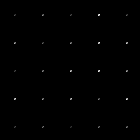

In [17]:
from IPython.display import Image
Image("/home/jehyuk/GenerativeModels/VAE/results/VAE/MNIST/VAE_epoch005.png")